# Image Denoising: Total Variation Regularization

The problem of removing noise from an image without blurring
sharp edges can be formulated as an infinite-dimensional minimization
problem. Given a possibly noisy image $d(x,y)$ defined within a
rectangular domain $\Omega$, we would like to
find the image $m(x,y)$ that is closest in the $L_2$ sense, i.e. we
want to minimize 

$$ \mathcal{J}_{LS} := \frac{1}{2}\int_\Omega (m - d)^2 \; d\boldsymbol{x}, $$


while also removing noise, which is assumed to comprise very *rough*
components of the image. This latter goal can be incorporated as an
additional term in the objective, in the form of a penalty. 

As we observed in the *Image Denoising: Tikhonov regularization* notebook,
the Tikhonov regularization functional,
$$ \mathcal{R}_{TN} := \! \frac{\alpha}{2}\int_\Omega \nabla m
\cdot \! \nabla m \; d\boldsymbol{x}, $$
has the tendency of blurring sharp edges in the image.

Instead,
in these cases we prefer the so-called *total variation (TV)
regularization*,

$$ \mathcal{R}_{TV} := \! \alpha\int_\Omega (\nabla m \cdot \! \nabla
m)^{\frac{1}{2}} \; d\boldsymbol{x} $$

where (we will see that) taking the square root is the key to
preserving edges. Since 
$\mathcal{R}_{TV}$ is not differentiable when $\nabla m =
\boldsymbol{0}$, it is usually modified to include a positive parameter
$\beta$ as follows:

$$ \mathcal{R}^{\beta}_{TV} := \!  \alpha \int_\Omega (\nabla m \cdot
\! \nabla m + \beta)^{\frac{1}{2}} \; d\boldsymbol{x}. $$

## 1. Python imports

We import the following libraries:

- `__future__`, which allows compatibility between different version of Python (Python 2 v.s. Python 3)
- `math`, which contains several mathematical functions
- `matplotlib, numpy, scipy`, three libraries that together allow similar functionalities to matlab
- `dolfin`, which allows us to discretize and solve variational problems using the finite element method
- `hippylib`, the extesible framework I created to solve inverse problems in Python
- `unconstrainedMinimization`, which has a Python implementation of the inexact Newton Conjuge Gradient algorithm that used in Assignment 3

Finally, we import the `logging` library to silence most of the output produced by `dolfin`.

In [1]:
from __future__ import print_function, division, absolute_import

import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.io as sio

import dolfin as dl

from hippylib import nb

from unconstrainedMinimization import InexactNewtonCG


import logging

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

--- Instant: compiling ---
--- Instant: compiling ---
--- Instant: compiling ---
--- Instant: compiling ---


## 2. The image class

The `Image` class is an extension of the `dolfin` class `Expression`, and allows us to convert from an image represented as a 2d array of pixels values to an object that `dolfin` can use to construct variational forms.

The constructor of the `Image` class takes the following inputs:

- `Lx`, `Ly`: the dimension of the image in physical units
- `data`: a numpy array of size Nx pixels by Ny pixels.

The `eval` function takes as input a point `x` in the physical coordinate systems an returns in the array `values` the value of the image in the pixels corresponding to point `x`.

In [3]:
class Image(dl.Expression):
    def __init__(self, Lx, Ly, data, **kwargs):
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]

## 3. Geometry, true image, and data.

1. Read the true image from file, store the pixel values in `data`

2. Define the width `Lx` and height `Ly` of the region of iterest such that the aspect ratio of the image is preserved.

3. Generate a triangulation (pixelation) `mesh` of the region of interest.

4. Define the finite element space `V` of piecewise linear function on the elements of `mesh`. This represent the space of discretized images.

5. Interpolate the true image in the discrete space `V`. Call this interpolation `m_true`.

6. Corrupt the true image with i.i.d. Gaussian noise ($\sigma^2 = 0.09$) and interpolated the noisy image in the discrete space `V`. Call this interpolation `d`.

7. Visualize the true image `m_true` and the noisy image `d`.

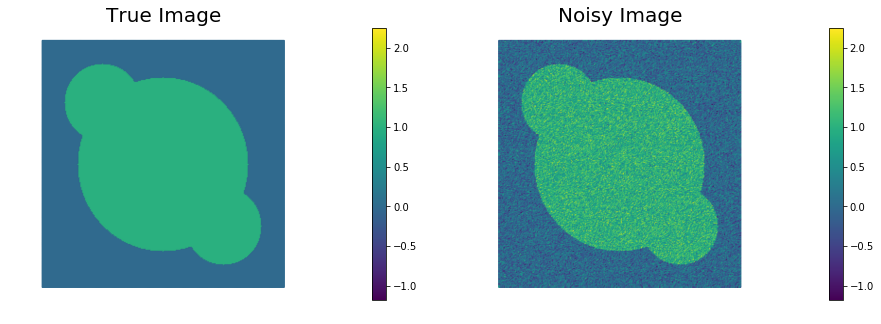

In [4]:
data = sio.loadmat('circles.mat')['im']

Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.
  
mesh = dl.RectangleMesh(dl.Point(0,0),dl.Point(Lx,Ly),data.shape[1], data.shape[0])
V = dl.FunctionSpace(mesh, "Lagrange",1)

trueImage = Image(Lx,Ly,data,degree = 1)
m_true  = dl.interpolate(trueImage, V)

np.random.seed(seed=1)
noise_std_dev = .3
noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
noisyImage = Image(Lx,Ly,data+noise, degree = 1)
d = dl.interpolate(noisyImage, V)

# Get min/max of noisy image, so that we can show all plots in the same scale
vmin = np.min(d.vector().get_local())
vmax = np.max(d.vector().get_local())

plt.figure(figsize=(15,5))
nb.plot(m_true, subplot_loc=121, mytitle="True Image", vmin=vmin, vmax = vmax)
nb.plot(d, subplot_loc=122, mytitle="Noisy Image", vmin=vmin, vmax = vmax)
plt.show()

## 4. Total Variation denoising

The class `TVDenosing` defines the cost functional and its first & second variations for the Total Variation denoising problem.

Specifically, the cost functional reads
$$ \mathcal{J}(m) = \frac{1}{2}\int_\Omega (m - d)^2 \; d\boldsymbol{x} + \frac{\alpha}{2}\int_\Omega \left( \nabla m \cdot \nabla m + \beta \right)^{\frac{1}{2}} d\boldsymbol{x}, $$
where $\alpha$ is the amount of regularization and $\beta$ is a small pertubation to ensure differentiability of the total variation functional.

The first variation of $\mathcal{J}$ reads
$$ \delta_m \mathcal{J}(m, \tilde{m}) = \int_\Omega (m - m_0)\tilde{m}  \; d\boldsymbol{x} + \alpha \int_\Omega \frac{1}{\left( \nabla m \cdot \nabla m + \beta \right)^{\frac{1}{2}}}\nabla m \cdot \nabla \tilde{m}  d\boldsymbol{x}, $$
and the second variation is
$$ \delta_m^2 \mathcal{J}(m, \tilde{m}, \hat{m}) = \int_\Omega \tilde{m} \hat{m} \; d\boldsymbol{x} + \alpha \int_\Omega \frac{1}{\left( \nabla m \cdot \nabla m + \beta \right)^{\frac{1}{2}}} \left[ \left( I - \frac{\nabla m \otimes \nabla m}{\nabla m \cdot \nabla m + \beta}\right) \nabla \tilde{m}\right] \cdot \nabla \hat{m} d\boldsymbol{x}. $$

The highly nonlinear coefficient $A = \left( I - \frac{\nabla m \otimes \nabla m}{\nabla m \cdot \nabla m + \beta}\right) $ in the second variation poses a substantial challange for the convergence of the Newton's method. In fact, the converge radius of the Newtos's method is extremely small.
For this reason in the following we will replace the second variation with the variational form
$$ \delta_m^2 \mathcal{J}_{\rm approx}(m, \tilde{m}, \hat{m}) = \int_\Omega \tilde{m}\,\hat{m} \; d\boldsymbol{x} + \alpha \int_\Omega \frac{1}{\left( \nabla m \cdot \nabla m + \beta \right)^{\frac{1}{2}}} \nabla \tilde{m} \cdot \nabla \hat{m} d\boldsymbol{x}. $$
The resulting method will exhibit only a first order convergence rate but it will be more robust for small values of $\beta$.

> For small values of $\beta$, there are more efficient methods for solving TV-regularized inverse problems than the basic Newton method we use here; in particular, so-called primal-dual Newton methods are preferred (see T.F. Chan, G.H. Golub, and P. Mulet, *A nonlinear primal-dual method for total variation-based image restoration*, SIAM Journal on Scientific Computing, 20(6):1964–1977, 1999).

In [5]:
class TVDenoising:
    def __init__(self, V, d, alpha, beta):
        self.alpha   = dl.Constant(alpha)
        self.beta    = dl.Constant(beta)
        self.d       = d
        self.m_tilde  = dl.TestFunction(V)
        self.m_hat = dl.TrialFunction(V)
        
    def cost_reg(self, m):
        return dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)*dl.dx
    
    def cost_misfit(self, m):
        return dl.Constant(.5)*dl.inner(m-self.d, m - self.d)*dl.dx
        
    def cost(self, m):        
        return self.cost_misfit(m) + self.alpha*self.cost_reg(m)
        
    def grad(self, m):    
        grad_ls = dl.inner(self.m_tilde, m - self.d)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        grad_tv = dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(self.m_tilde))*dl.dx
        
        grad = grad_ls + self.alpha*grad_tv
        
        return grad
        
    def Hessian(self,m):
        H_ls = dl.inner(self.m_tilde, self.m_hat)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        A = dl.Constant(1.)/TVm * (dl.Identity(2) - dl.outer(dl.grad(m)/TVm, dl.grad(m)/TVm ) )
        H_tv = dl.inner(A*dl.grad(self.m_tilde), dl.grad(self.m_hat))*dl.dx
         
        H = H_ls + self.alpha*H_tv
                                   
        return H
    
    def LD_Hessian(self,m):
        H_ls = dl.inner(self.m_tilde, self.m_hat)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        H_tv = dl.Constant(1.)/TVm *dl.inner(dl.grad(self.m_tilde), dl.grad(self.m_hat))*dl.dx
         
        H = H_ls + self.alpha*H_tv
                                   
        return H
            
        

## 5. Finite difference check of the gradient

We use a *finite difference check* to verify that our implementation of the gradient is correct. 

Specifically, we consider an arbitrary chosen function $m_0=x(x−1)y(y−1)$ and we verify that for a random direction $\tilde{m}$ we have

$$
r:=\left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m})−\mathcal{J}(m_0) }{h} - \delta_m \mathcal{J}(m_0, \tilde{m})\right|=\mathcal{O}(\varepsilon).
$$

In the figure below we plot in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.

--- Instant: compiling ---


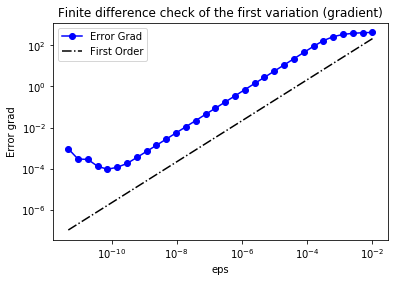

In [6]:
n_eps = 32
eps = 1e-2*np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m0 = dl.interpolate(dl.Expression("x[0]*(x[0]-1)*x[1]*(x[1]-1)", degree=4), V)
alpha = 1.
beta   = 1e-4
problem = TVDenoising(V,d,alpha, beta)

J0 = dl.assemble( problem.cost(m0) )
grad0 = dl.assemble(problem.grad(m0) )

mtilde = dl.Function(V)
mtilde.vector().set_local(np.random.randn(V.dim()))
mtilde.vector().apply("")

mtilde_grad0 = grad0.inner(mtilde.vector())

for i in range(n_eps):
    Jplus = dl.assemble( problem.cost(m0 + dl.Constant(eps[i])*mtilde) )
    err_grad[i] = abs( (Jplus - J0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

## 5. Finite difference check of the Hessian

As before, we verify that for a random direction $\hat{m}$ we have 

$$
r:=\left\| \frac{\delta_m\mathcal{J}(m_0+\varepsilon\hat{m},\tilde{m} ) - \delta_m\mathcal{J}(m_0,\tilde{m} )}{\varepsilon} - \delta^2_m\mathcal{J}(m_0,\tilde{m}, \hat{m})\right\| = \mathcal{O}(\varepsilon).
$$

In the figure below we show in a loglog scale the value of $r$
as a function of $\varepsilon$. As before, we observe that $r$ decays linearly for a wide range of values of $\varepsilon$.

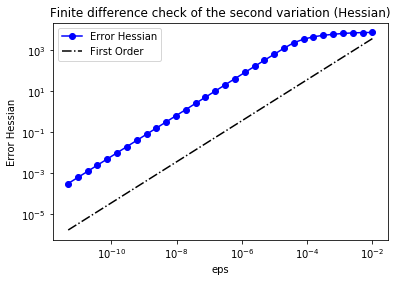

In [7]:
H_0 = dl.assemble( problem.Hessian(m0) )
H_0mtilde = H_0 * mtilde.vector()
err_H = np.zeros(n_eps)

for i in range(n_eps):
    grad_plus = dl.assemble( problem.grad(m0 + dl.Constant(eps[i])*mtilde) )
    diff_grad = (grad_plus - grad0)
    diff_grad *= 1/eps[i]
    err_H[i] = (diff_grad - H_0mtilde).norm("l2")
    
plt.figure()    
plt.loglog(eps, err_H, "-ob", label="Error Hessian")
plt.loglog(eps, (.5*err_H[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the second variation (Hessian)")
plt.xlabel("eps")
plt.ylabel("Error Hessian")
plt.legend(loc = "upper left")
plt.show()


## 5. Solution of Total Variation regularized Denoising problem.

The function `TVsolution` computes the solution of the denoising inverse problem using Total Variation regularization for a given amount a regularization $\alpha$ and perturbation $\varepsilon$.

To minimize the cost cost functional $\mathcal{J}(m)$, we use the *infinite-dimensional* Newton's method with linesearch globalization.

1. Given the current solution $m_k$, find the Newton's direction $\hat{m}_k$ such that

$$ \delta^2_m\mathcal{J}(m_k,\tilde{m}, \hat{u}_k )=−\delta_m\mathcal{J}(m_k,\tilde{m}) \quad \forall \tilde{m}.$$

2. Update the solution using the Newton direction $\hat{m}_k$

$$ m_{k+1}=m_k+ \alpha_k \hat{m}_k, $$

where the step length $\alpha_k$ is computed using backtracking to the ensure sufficient descent condition.

The class `InexactNewtonCG` implements the inexact Newton conjugate gradient algorithm to solve the discretized version of the *infinite-dimensional* Newton's method above.

Finally, since we also know the true image `m_true` (*this will not be the case for real applications*)
we can also write the true $L_2$ error functional 
$$ MSE := \frac{1}{2}\int_\Omega (m - m_{\rm true})^2 \; d\boldsymbol{x}. $$

In [8]:
def TVsolution(alpha, beta):
    
    m = dl.Function(V)
    problem = TVDenoising(V, d, alpha, beta)
    
    solver = InexactNewtonCG()
    solver.parameters["rel_tolerance"] = 1e-5
    solver.parameters["abs_tolerance"] = 1e-9
    solver.parameters["gdm_tolerance"] = 1e-18
    solver.parameters["max_iter"] = 1000
    solver.parameters["c_armijo"] = 1e-5
    solver.parameters["print_level"] = -1
    solver.parameters["max_backtracking_iter"] = 10
    solver.solve(problem.cost, problem.grad, problem.Hessian, m)
    
    MSE  = dl.inner(m - m_true, m - m_true)*dl.dx
    J    = problem.cost(m)
    J_ls = problem.cost_misfit(m)
    R_tv = problem.cost_reg(m)

    print( "{0:15e} {1:15e} {2:4d} {3:15e} {4:15e} {5:15e} {6:15e}".format(
           alpha, beta, solver.it, dl.assemble(J), dl.assemble(J_ls), dl.assemble(R_tv), dl.assemble(MSE))
         )

    return m


## 6. Compute the denoised image for different amout of regularization

We define some values of $\alpha$ ($\alpha = 10^{-1}, 10^{-2}, 10^{-3}, 10^{-4}$) for the choice of the regularization paramenter.

The best reconstruction of the original image is obtained for $\alpha = 10^{-3}$. We also notice that Total Variation does a much better job that Tikhonov regularization in preserving the sharp edges of the original image.

alpha           beta            nit  J               J_ls            R_tv            MSE            
   1.000000e-01    1.000000e-04    8    1.468304e-01    1.451551e-01    1.675282e-02    2.453196e-01
   1.000000e-02    1.000000e-04   74    5.217886e-02    2.692285e-02    2.525602e+00    9.146505e-03
   1.000000e-03    1.000000e-04  921    2.521711e-02    2.189623e-02    3.320886e+00    7.971665e-04
   1.000000e-04    1.000000e-04  189    1.031940e-02    2.703557e-03    7.615843e+01    2.506756e-02


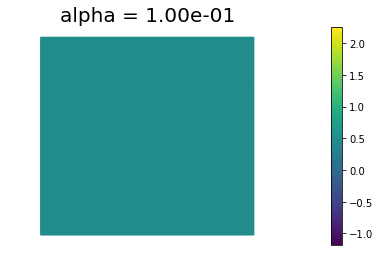

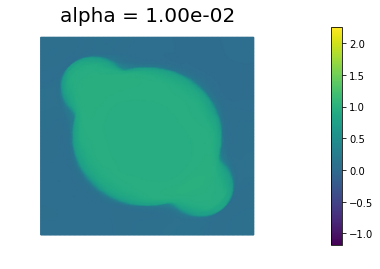

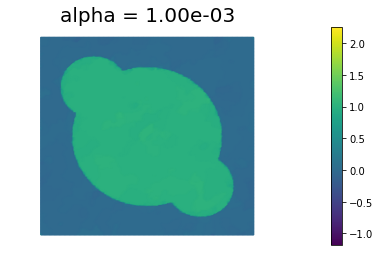

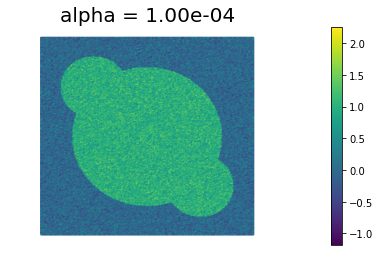

In [11]:
print ("{0:15} {1:15} {2:4} {3:15} {4:15} {5:15} {6:15}".format("alpha", "beta", "nit", "J", "J_ls", "R_tv", "MSE") )

beta = 1e-4
n_alphas = 4
alphas = np.power(10., -np.arange(1, n_alphas+1))
for alpha in alphas:
    m = TVsolution(alpha, beta)
    plt.figure()
    nb.plot(m, vmin=vmin, vmax = vmax, mytitle="alpha = {0:1.2e}".format(alpha))
plt.show()

alpha           beta            nit  J               J_ls            R_tv            MSE            
   1.000000e-03    1.000000e+01   19    2.748766e-02    2.079902e-02    6.688631e+00    1.262773e-03
   1.000000e-03    1.000000e+00   40    2.584654e-02    2.148072e-02    4.365817e+00    9.500933e-04
   1.000000e-03    1.000000e-01   66    2.538788e-02    2.176078e-02    3.627106e+00    8.387293e-04
   1.000000e-03    1.000000e-02  147    2.526200e-02    2.185685e-02    3.405153e+00    8.064175e-04
   1.000000e-03    1.000000e-03  360    2.522709e-02    2.188693e-02    3.340160e+00    7.987682e-04
   1.000000e-03    1.000000e-04  921    2.521711e-02    2.189623e-02    3.320886e+00    7.971665e-04


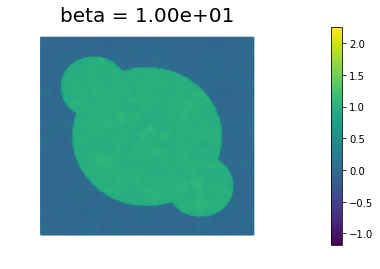

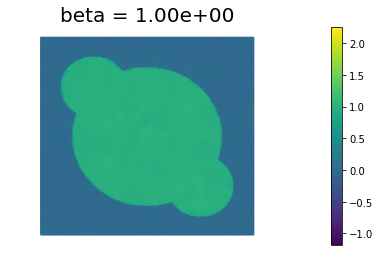

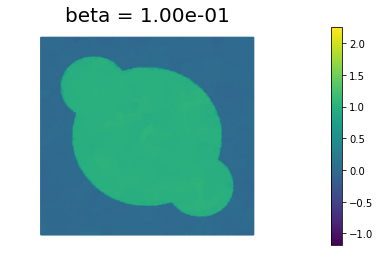

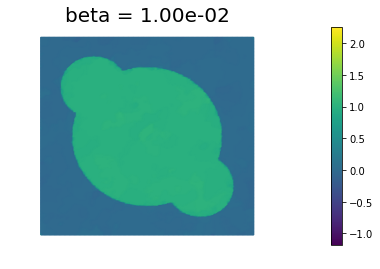

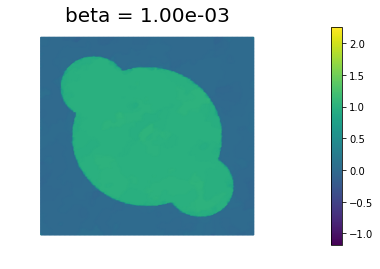

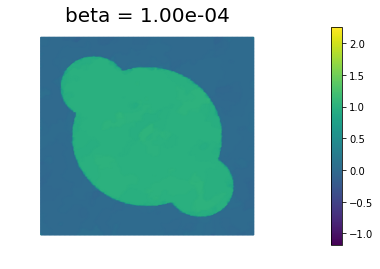

In [12]:
# Xiaohui Zhang
print ("{0:15} {1:15} {2:4} {3:15} {4:15} {5:15} {6:15}".format("alpha", "beta", "nit", "J", "J_ls", "R_tv", "MSE") )

betas = (10,1,0.1,0.01,0.001,0.0001)
alpha = 0.001
# alphas = np.power(10., -np.arange(1, n_alphas+1))
for beta in betas:
    m = TVsolution(alpha, beta)
    plt.figure()
    nb.plot(m, vmin=vmin, vmax = vmax, mytitle="beta = {0:1.2e}".format(beta))
plt.show()

---

Copyright &copy; 2019, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for the S2019 BME 493/593 course on *Computational Methods in Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.